In [59]:
# 필요한 라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import json
import os
import sys
from collections import Counter
import re
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

# 프로젝트 루트 디렉토리를 Python path에 추가
sys.path.append('../')
from src.data_loader import AlpacaDataLoader
from src.analysis import parse_filename_info

# 한글 폰트 설정 (matplotlib)
plt.rcParams['font.family'] = ['DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# 시각화 스타일 설정
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

print("라이브러리 로딩 완료!")

라이브러리 로딩 완료!


In [60]:
# 데이터 로더 초기화 (data 디렉토리 경로 수정)
loader = AlpacaDataLoader(data_dir="../data")

# 사용 가능한 데이터 파일들 확인
data_dir = "../data"
if os.path.exists(data_dir):
    data_files = [f for f in os.listdir(data_dir) if f.endswith('.json') and f.startswith('alpaca_')]
    print(f"발견된 데이터 파일: {len(data_files)}개")
    for file in sorted(data_files):
        print(f"  - {file}")
else:
    print("데이터 디렉토리가 없습니다. 먼저 main.py --demo를 실행해주세요.")
    data_files = []

발견된 데이터 파일: 3개
  - alpaca_full_20percent_52002.json
  - alpaca_full_dataset.json
  - alpaca_original_full_52002.json


In [61]:
# 원본 데이터셋 로딩 (데모 또는 전체)
original_files = [f for f in data_files if 'original' in f]

if original_files:
    # 데모 파일 우선, 없으면 전체 파일 사용
    demo_original = [f for f in original_files if 'demo' in f]
    if demo_original:
        original_file = demo_original[0]
        print(f"데모 원본 파일 사용: {original_file}")
    else:
        original_file = original_files[0]
        print(f"전체 원본 파일 사용: {original_file}")
    
    # 전체 파일 경로로 직접 로딩
    full_path = os.path.join("../data", original_file)
    df_original = pd.read_json(full_path)
    
    if df_original is not None:
        print(f"\n원본 데이터 로딩 완료: {len(df_original)}개 샘플")
    else:
        print(f"\n데이터 로딩 실패: {original_file}")
        print("데이터 파일이 존재하지 않거나 손상되었을 수 있습니다.")
        print("main.py --demo 또는 main.py --full 을 먼저 실행해주세요.")
else:
    print("원본 데이터 파일이 없습니다. 먼저 데이터를 생성해주세요.")
    df_original = None

전체 원본 파일 사용: alpaca_original_full_52002.json

원본 데이터 로딩 완료: 52002개 샘플


In [62]:
# 원본 데이터셋 로딩 (데모 또는 전체)

if original_files:
    # 데모 파일 우선, 없으면 전체 파일 사용
    demo_original = [f for f in original_files if 'demo' in f]
    if demo_original:
        original_file = demo_original[0]
        print(f"데모 원본 파일 사용: {original_file}")
    else:
        original_file = original_files[0]
        print(f"전체 원본 파일 사용: {original_file}")
    
    df_original = loader.load_saved_dataset(original_file)
    print(f"\n원본 데이터 로딩 완료: {len(df_original)}개 샘플")
else:
    print("원본 데이터 파일이 없습니다. 먼저 데이터를 생성해주세요.")
    df_original = None

전체 원본 파일 사용: alpaca_original_full_52002.json
저장된 데이터셋을 로드했습니다: ../data/alpaca_original_full_52002.json

원본 데이터 로딩 완료: 52002개 샘플


## 2. 기본 데이터 구조 분석

In [64]:
if df_original is not None:
    print("=== 기본 데이터 정보 ===")
    print(f"데이터 크기: {df_original.shape}")
    print(f"컬럼: {list(df_original.columns)}")
    print(f"\n=== 데이터 타입 ===")
    print(df_original.dtypes)
    
    print(f"\n=== 결측값 확인 ===")
    print(df_original.isnull().sum())
    
    print(f"\n=== 샘플 데이터 ===")
    display(df_original.head(3))

=== 기본 데이터 정보 ===
데이터 크기: (52002, 4)
컬럼: ['instruction', 'input', 'output', 'text']

=== 데이터 타입 ===
instruction    object
input          object
output         object
text           object
dtype: object

=== 결측값 확인 ===
instruction    0
input          0
output         0
text           0
dtype: int64

=== 샘플 데이터 ===


,instruction,input,output,text
0,Give three tips for staying healthy.,,1.Eat a balanced diet and make sure to include...,Below is an instruction that describes a task....
1,What are the three primary colors?,,"The three primary colors are red, blue, and ye...",Below is an instruction that describes a task....
2,Describe the structure of an atom.,,"An atom is made up of a nucleus, which contain...",Below is an instruction that describes a task....


## 3. 텍스트 길이 분석

In [65]:
if df_original is not None:
    # 텍스트 길이 계산
    df_original['instruction_length'] = df_original['instruction'].str.len()
    df_original['output_length'] = df_original['output'].str.len()
    
    # input 필드가 있다면 길이 계산
    if 'input' in df_original.columns:
        df_original['input_length'] = df_original['input'].fillna('').str.len()
    
    # 기본 통계
    print("=== 텍스트 길이 통계 ===")
    length_stats = df_original[['instruction_length', 'output_length']].describe()
    display(length_stats)

=== 텍스트 길이 통계 ===


,instruction_length,output_length
count,52002.000000,52002.000000
mean,59.778759,270.312334
std,21.193591,275.025960
min,9.000000,0.000000
25%,46.000000,53.000000
50%,57.000000,185.000000
75%,70.000000,423.000000
max,489.000000,4181.000000


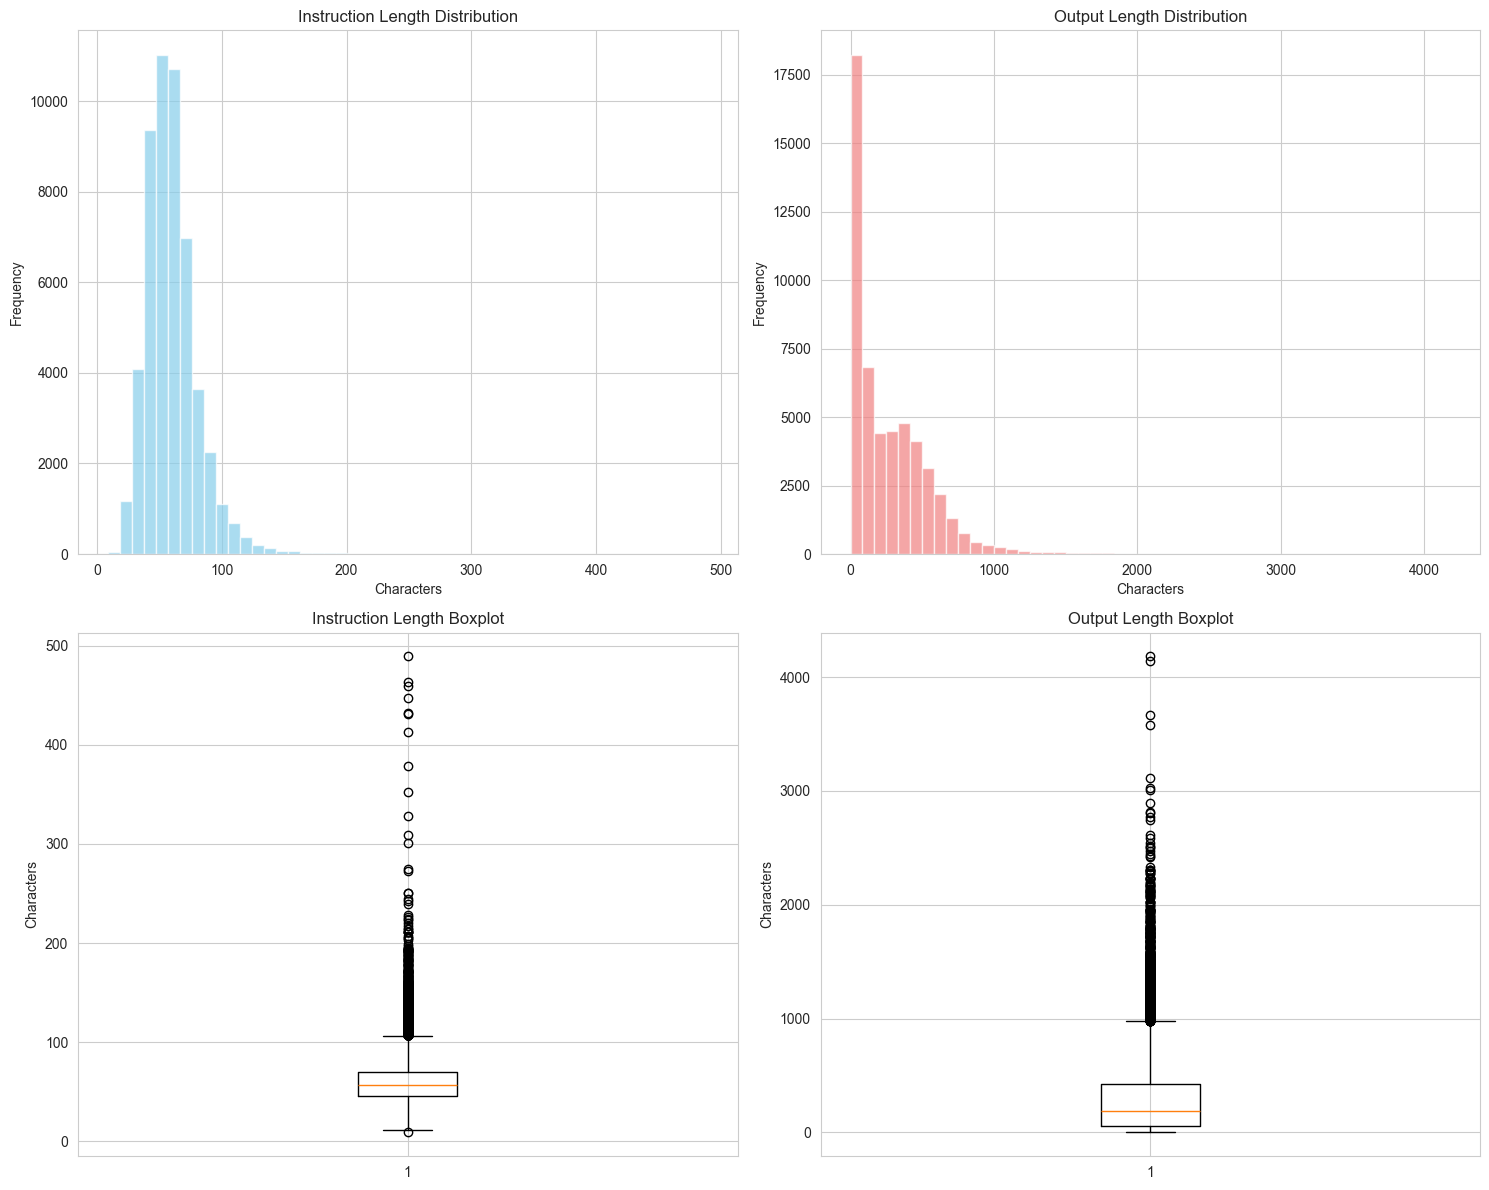

In [66]:
if df_original is not None:
    # 텍스트 길이 분포 시각화
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Instruction 길이 히스토그램
    axes[0, 0].hist(df_original['instruction_length'], bins=50, alpha=0.7, color='skyblue')
    axes[0, 0].set_title('Instruction Length Distribution')
    axes[0, 0].set_xlabel('Characters')
    axes[0, 0].set_ylabel('Frequency')
    
    # Output 길이 히스토그램
    axes[0, 1].hist(df_original['output_length'], bins=50, alpha=0.7, color='lightcoral')
    axes[0, 1].set_title('Output Length Distribution')
    axes[0, 1].set_xlabel('Characters')
    axes[0, 1].set_ylabel('Frequency')
    
    # Instruction 길이 박스플롯
    axes[1, 0].boxplot(df_original['instruction_length'])
    axes[1, 0].set_title('Instruction Length Boxplot')
    axes[1, 0].set_ylabel('Characters')
    
    # Output 길이 박스플롯
    axes[1, 1].boxplot(df_original['output_length'])
    axes[1, 1].set_title('Output Length Boxplot')
    axes[1, 1].set_ylabel('Characters')
    
    plt.tight_layout()
    plt.show()

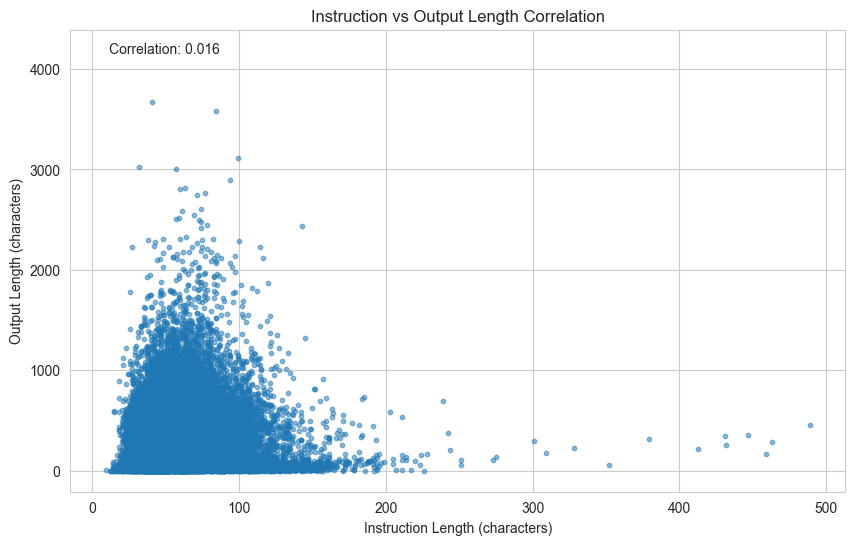

In [67]:
if df_original is not None:
    # Instruction vs Output 길이 상관관계
    plt.figure(figsize=(10, 6))
    plt.scatter(df_original['instruction_length'], df_original['output_length'], 
                alpha=0.5, s=10)
    plt.xlabel('Instruction Length (characters)')
    plt.ylabel('Output Length (characters)')
    plt.title('Instruction vs Output Length Correlation')
    
    # 상관계수 계산
    correlation = df_original['instruction_length'].corr(df_original['output_length'])
    plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
             transform=plt.gca().transAxes, bbox=dict(boxstyle='round', facecolor='white'))
    
    plt.show()

## 4. 텍스트 복잡도 분석

In [68]:
if df_original is not None:
    # 단어 수 계산
    df_original['instruction_words'] = df_original['instruction'].str.split().str.len()
    df_original['output_words'] = df_original['output'].str.split().str.len()
    
    # 문장 수 계산 (마침표 기준)
    df_original['instruction_sentences'] = df_original['instruction'].str.count('\.') + 1
    df_original['output_sentences'] = df_original['output'].str.count('\.') + 1
    
    # 평균 단어 길이
    df_original['avg_word_length_inst'] = df_original['instruction_length'] / df_original['instruction_words']
    df_original['avg_word_length_out'] = df_original['output_length'] / df_original['output_words']
    
    print("=== 텍스트 복잡도 통계 ===")
    complexity_cols = ['instruction_words', 'output_words', 'instruction_sentences', 
                      'output_sentences', 'avg_word_length_inst', 'avg_word_length_out']
    complexity_stats = df_original[complexity_cols].describe()
    display(complexity_stats)

=== 텍스트 복잡도 통계 ===


,instruction_words,output_words,instruction_sentences,output_sentences,avg_word_length_inst,avg_word_length_out
count,52002.000000,52002.000000,52002.000000,52002.000000,52002.000000,51974.000000
mean,10.063632,44.182858,1.763355,3.876293,6.007817,6.207500
std,3.628237,44.974091,0.482414,3.444933,0.842798,2.692700
min,4.000000,0.000000,1.000000,1.000000,1.800000,1.000000
25%,8.000000,9.000000,1.000000,2.000000,5.444444,5.444444
50%,10.000000,30.000000,2.000000,3.000000,5.928571,6.000000
75%,12.000000,69.000000,2.000000,5.000000,6.500000,6.653061
max,84.000000,717.000000,12.000000,108.000000,32.600000,160.000000


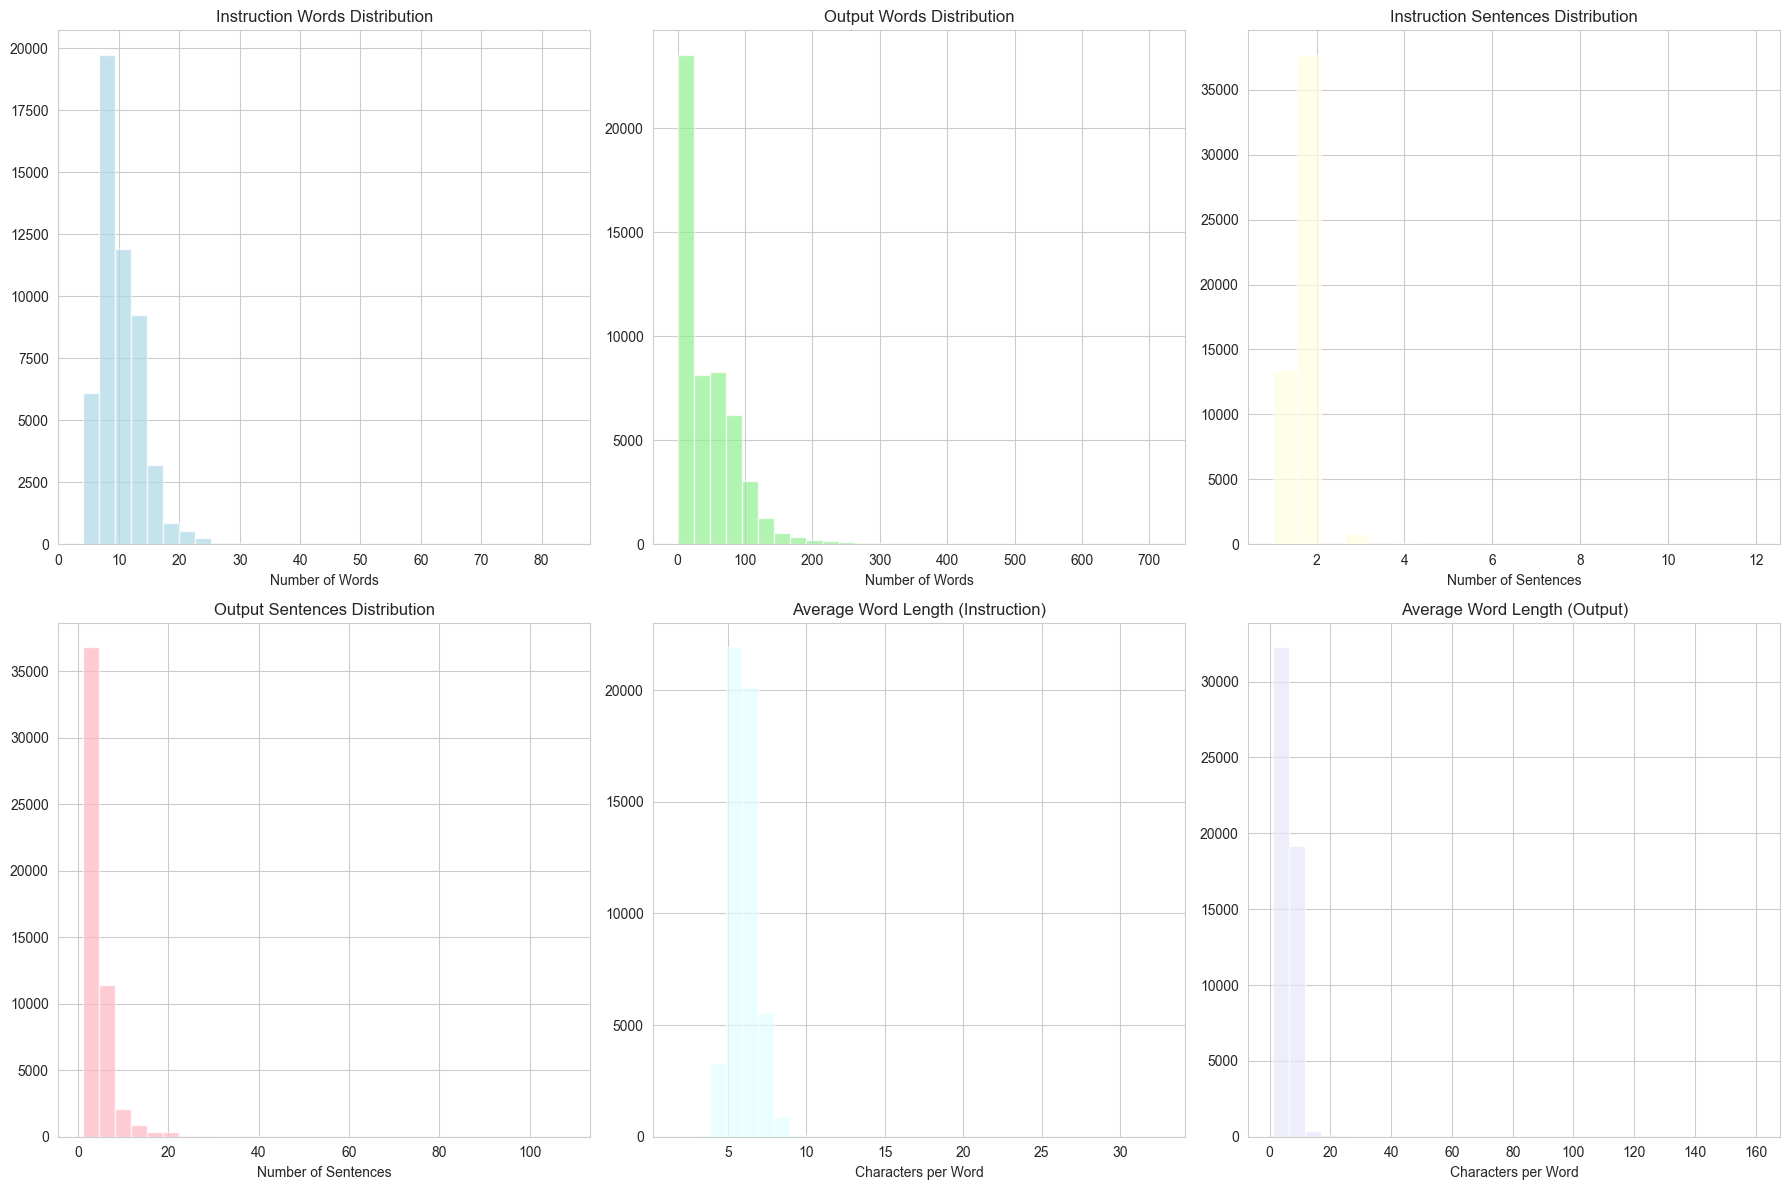

In [69]:
if df_original is not None:
    # 복잡도 지표 시각화
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # 단어 수 분포
    axes[0, 0].hist(df_original['instruction_words'], bins=30, alpha=0.7, color='lightblue')
    axes[0, 0].set_title('Instruction Words Distribution')
    axes[0, 0].set_xlabel('Number of Words')
    
    axes[0, 1].hist(df_original['output_words'], bins=30, alpha=0.7, color='lightgreen')
    axes[0, 1].set_title('Output Words Distribution')
    axes[0, 1].set_xlabel('Number of Words')
    
    # 문장 수 분포
    axes[0, 2].hist(df_original['instruction_sentences'], bins=20, alpha=0.7, color='lightyellow')
    axes[0, 2].set_title('Instruction Sentences Distribution')
    axes[0, 2].set_xlabel('Number of Sentences')
    
    axes[1, 0].hist(df_original['output_sentences'], bins=30, alpha=0.7, color='lightpink')
    axes[1, 0].set_title('Output Sentences Distribution')
    axes[1, 0].set_xlabel('Number of Sentences')
    
    # 평균 단어 길이
    axes[1, 1].hist(df_original['avg_word_length_inst'], bins=30, alpha=0.7, color='lightcyan')
    axes[1, 1].set_title('Average Word Length (Instruction)')
    axes[1, 1].set_xlabel('Characters per Word')
    
    axes[1, 2].hist(df_original['avg_word_length_out'], bins=30, alpha=0.7, color='lavender')
    axes[1, 2].set_title('Average Word Length (Output)')
    axes[1, 2].set_xlabel('Characters per Word')
    
    plt.tight_layout()
    plt.show()

In [70]:
if df_original is not None:
    # 가장 빈번한 단어들 (Instruction)
    all_instruction_words = ' '.join(df_original['instruction']).lower()
    # 간단한 전처리
    all_instruction_words = re.sub(r'[^a-zA-Z\s]', '', all_instruction_words)
    instruction_word_counts = Counter(all_instruction_words.split())

    # 불용어 제거 (간단한 버전)
    stop_words = {'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by',
                  'is', 'are', 'was', 'were', 'be', 'been', 'have', 'has', 'had', 'do', 'does', 'did',
                  'will', 'would', 'could', 'should', 'may', 'might', 'can', 'must', 'i', 'you', 'he',
                  'she', 'it', 'we', 'they', 'this', 'that', 'these', 'those', 'what', 'how', 'when',
                  'where', 'why', 'who', 'which'}

    filtered_words = {word: count for word, count in instruction_word_counts.items()
                     if word not in stop_words and len(word) > 2}

    print("=== Instruction에서 가장 빈번한 단어 (Top 20) ===")
    top_words = Counter(filtered_words).most_common(20)
    for word, count in top_words:
        print(f"{word}: {count}")
else:
    # df_original이 None일 때를 위한 기본값
    filtered_words = {}
    top_words = []

=== Instruction에서 가장 빈번한 단어 (Top 20) ===
following: 7406
given: 7305
sentence: 6966
generate: 5130
create: 4293
list: 4219
describe: 3547
write: 3102
about: 2957
two: 2878
explain: 2656
name: 2371
words: 2326
three: 2104
using: 2089
find: 1905
identify: 1881
from: 1857
make: 1689
word: 1628


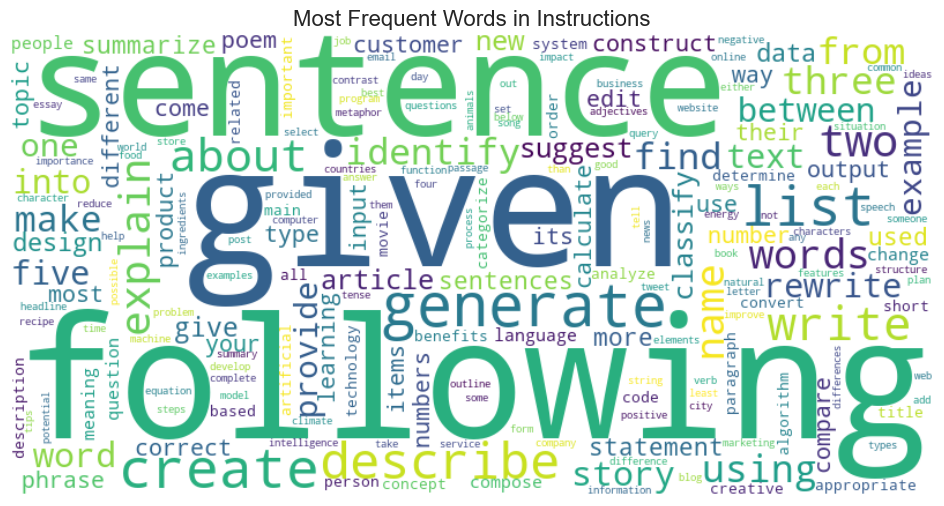

In [71]:
if df_original is not None and filtered_words:
    # 워드클라우드 생성 (Instruction)
    if WORDCLOUD_AVAILABLE:
        try:
            wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(filtered_words)
            
            plt.figure(figsize=(12, 6))
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.axis('off')
            plt.title('Most Frequent Words in Instructions', fontsize=16)
            plt.show()
        except Exception as e:
            print(f"워드클라우드 생성 실패: {e}")
    else:
        print("WordCloud 라이브러리가 없어서 워드클라우드를 건너뜁니다.")
        print("설치하려면: pip install wordcloud")
else:
    print("데이터가 없어서 워드클라우드를 건너뜁니다.")

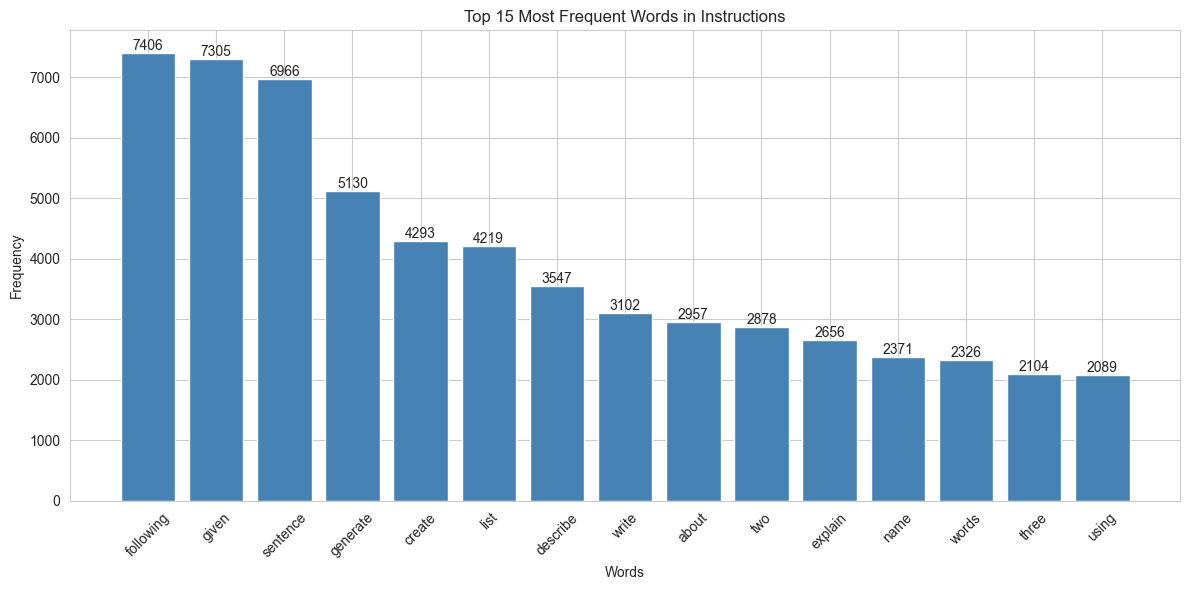

In [72]:
if df_original is not None and top_words:
    # 빈출 단어 시각화
    top_words_df = pd.DataFrame(top_words[:15], columns=['word', 'frequency'])
    
    plt.figure(figsize=(12, 6))
    bars = plt.bar(range(len(top_words_df)), top_words_df['frequency'], color='steelblue')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title('Top 15 Most Frequent Words in Instructions')
    plt.xticks(range(len(top_words_df)), top_words_df['word'], rotation=45)
    
    # 각 바 위에 빈도수 표시
    for i, bar in enumerate(bars):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                str(top_words_df.iloc[i]['frequency']), 
                ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
else:
    print("데이터가 없어서 단어 빈도 시각화를 건너뜁니다.")

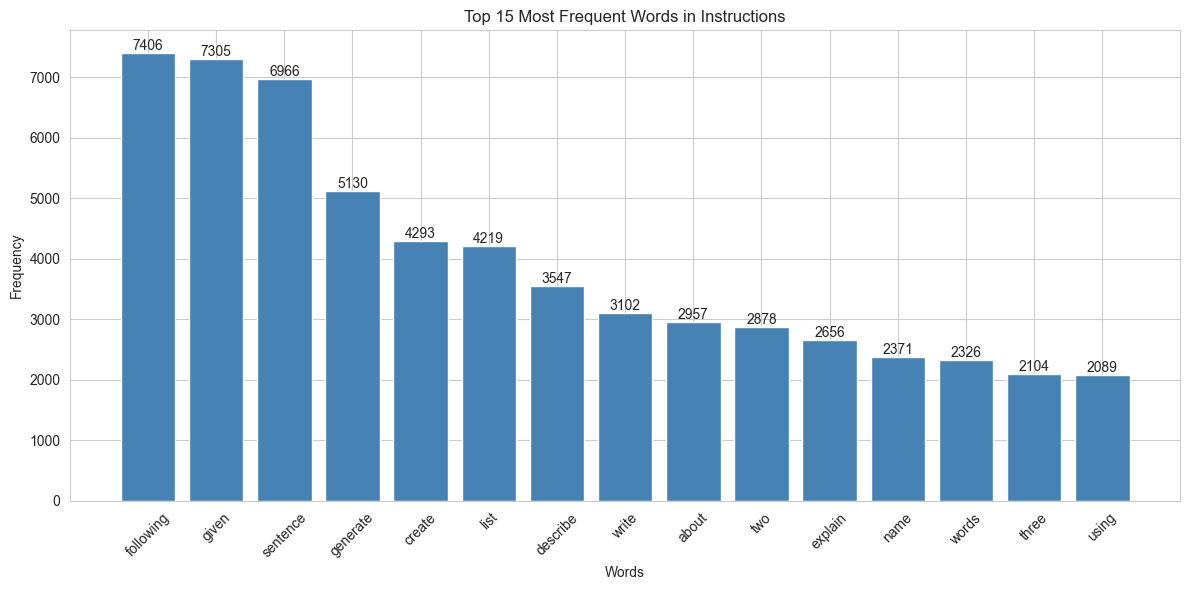

In [73]:
if df_original is not None:
    # 빈출 단어 시각화
    top_words_df = pd.DataFrame(top_words[:15], columns=['word', 'frequency'])
    
    plt.figure(figsize=(12, 6))
    bars = plt.bar(range(len(top_words_df)), top_words_df['frequency'], color='steelblue')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title('Top 15 Most Frequent Words in Instructions')
    plt.xticks(range(len(top_words_df)), top_words_df['word'], rotation=45)
    
    # 각 바 위에 빈도수 표시
    for i, bar in enumerate(bars):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                str(top_words_df.iloc[i]['frequency']), 
                ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

In [74]:
# 노이즈 주입된 파일들 찾기
noisy_files = [f for f in data_files if 'original' not in f]

if noisy_files and df_original is not None:
    print(f"발견된 노이즈 파일: {len(noisy_files)}개")

    # 파일 정보 파싱
    noisy_file_info = []
    for file in noisy_files:
        info = parse_filename_info(file)
        info['filename'] = file
        noisy_file_info.append(info)

    # 정보 출력
    noisy_df = pd.DataFrame(noisy_file_info)
    print("\n=== 노이즈 파일 정보 ===")
    display(noisy_df[['filename', 'type', 'noise_percent', 'strategy']].head(10))
else:
    print("노이즈 파일이 없습니다.")
    noisy_files = []

발견된 노이즈 파일: 2개

=== 노이즈 파일 정보 ===


,filename,type,noise_percent,strategy
0,alpaca_full_20percent_52002.json,experiment,20%,N/A
1,alpaca_full_dataset.json,experiment,N/A,N/A


In [75]:
# 첫 번째 노이즈 파일과 원본 비교
if noisy_files and df_original is not None:
    # 데모 노이즈 파일 우선 선택
    demo_noisy = [f for f in noisy_files if 'demo' in f]
    if demo_noisy:
        selected_noisy = demo_noisy[0]
    else:
        selected_noisy = noisy_files[0]
    
    print(f"비교 대상 노이즈 파일: {selected_noisy}")
    
    # 노이즈 데이터 로딩 (직접 경로 사용)
    full_path = os.path.join("../data", selected_noisy)
    df_noisy = pd.read_json(full_path)
    
    if df_noisy is not None:
        print(f"노이즈 데이터 로딩 완료: {len(df_noisy)}개 샘플")
        
        # 길이 비교
        df_noisy['instruction_length'] = df_noisy['instruction'].str.len()
        df_noisy['output_length'] = df_noisy['output'].str.len()
        
        print("\n=== 원본 vs 노이즈 데이터 길이 비교 ===")
        comparison = pd.DataFrame({
            'Original_Instruction': df_original['instruction_length'].describe(),
            'Noisy_Instruction': df_noisy['instruction_length'].describe(),
            'Original_Output': df_original['output_length'].describe(),
            'Noisy_Output': df_noisy['output_length'].describe()
        })
        display(comparison)
    else:
        print(f"노이즈 데이터 로딩 실패: {selected_noisy}")
        df_noisy = None
else:
    df_noisy = None

비교 대상 노이즈 파일: alpaca_full_20percent_52002.json
노이즈 데이터 로딩 완료: 52002개 샘플

=== 원본 vs 노이즈 데이터 길이 비교 ===


,Original_Instruction,Noisy_Instruction,Original_Output,Noisy_Output
count,52002.000000,52002.000000,52002.000000,52002.000000
mean,59.778759,59.803873,270.312334,267.914253
std,21.193591,21.195543,275.025960,273.953819
min,9.000000,9.000000,0.000000,0.000000
25%,46.000000,46.000000,53.000000,54.000000
50%,57.000000,57.000000,185.000000,180.000000
75%,70.000000,70.000000,423.000000,420.000000
max,489.000000,489.000000,4181.000000,4181.000000


In [76]:
# 첫 번째 노이즈 파일과 원본 비교
if noisy_files and df_original is not None:
    # 데모 노이즈 파일 우선 선택
    demo_noisy = [f for f in noisy_files if 'demo' in f]
    if demo_noisy:
        selected_noisy = demo_noisy[0]
    else:
        selected_noisy = noisy_files[0]
    
    print(f"비교 대상 노이즈 파일: {selected_noisy}")
    
    # 노이즈 데이터 로딩
    df_noisy = loader.load_saved_dataset(selected_noisy)
    
    if df_noisy is not None:
        print(f"노이즈 데이터 로딩 완료: {len(df_noisy)}개 샘플")
        
        # 길이 비교
        df_noisy['instruction_length'] = df_noisy['instruction'].str.len()
        df_noisy['output_length'] = df_noisy['output'].str.len()
        
        print("\n=== 원본 vs 노이즈 데이터 길이 비교 ===")
        comparison = pd.DataFrame({
            'Original_Instruction': df_original['instruction_length'].describe(),
            'Noisy_Instruction': df_noisy['instruction_length'].describe(),
            'Original_Output': df_original['output_length'].describe(),
            'Noisy_Output': df_noisy['output_length'].describe()
        })
        display(comparison)

비교 대상 노이즈 파일: alpaca_full_20percent_52002.json
저장된 데이터셋을 로드했습니다: ../data/alpaca_full_20percent_52002.json
노이즈 데이터 로딩 완료: 52002개 샘플

=== 원본 vs 노이즈 데이터 길이 비교 ===


,Original_Instruction,Noisy_Instruction,Original_Output,Noisy_Output
count,52002.000000,52002.000000,52002.000000,52002.000000
mean,59.778759,59.803873,270.312334,267.914253
std,21.193591,21.195543,275.025960,273.953819
min,9.000000,9.000000,0.000000,0.000000
25%,46.000000,46.000000,53.000000,54.000000
50%,57.000000,57.000000,185.000000,180.000000
75%,70.000000,70.000000,423.000000,420.000000
max,489.000000,489.000000,4181.000000,4181.000000


In [77]:
if noisy_files and df_original is not None and df_noisy is not None:
    # 변경된 샘플 찾기
    changed_indices = []
    for i in range(len(df_original)):
        if (df_original.iloc[i]['instruction'] != df_noisy.iloc[i]['instruction'] or 
            df_original.iloc[i]['output'] != df_noisy.iloc[i]['output']):
            changed_indices.append(i)
    
    print(f"변경된 샘플 수: {len(changed_indices)} / {len(df_original)} ({len(changed_indices)/len(df_original)*100:.1f}%)")
    
    # 길이 변화 분석
    if changed_indices:
        length_changes = []
        for idx in changed_indices:
            orig_len = len(df_original.iloc[idx]['output'])
            noisy_len = len(df_noisy.iloc[idx]['output'])
            length_changes.append(noisy_len - orig_len)
        
        print(f"\n=== 길이 변화 통계 ===")
        print(f"평균 길이 변화: {np.mean(length_changes):.1f} 문자")
        print(f"최대 증가: {max(length_changes)} 문자")
        print(f"최대 감소: {min(length_changes)} 문자")
        print(f"표준편차: {np.std(length_changes):.1f} 문자")

변경된 샘플 수: 10399 / 52002 (20.0%)

=== 길이 변화 통계 ===
평균 길이 변화: -12.0 문자
최대 증가: 2539 문자
최대 감소: -3114 문자
표준편차: 182.3 문자


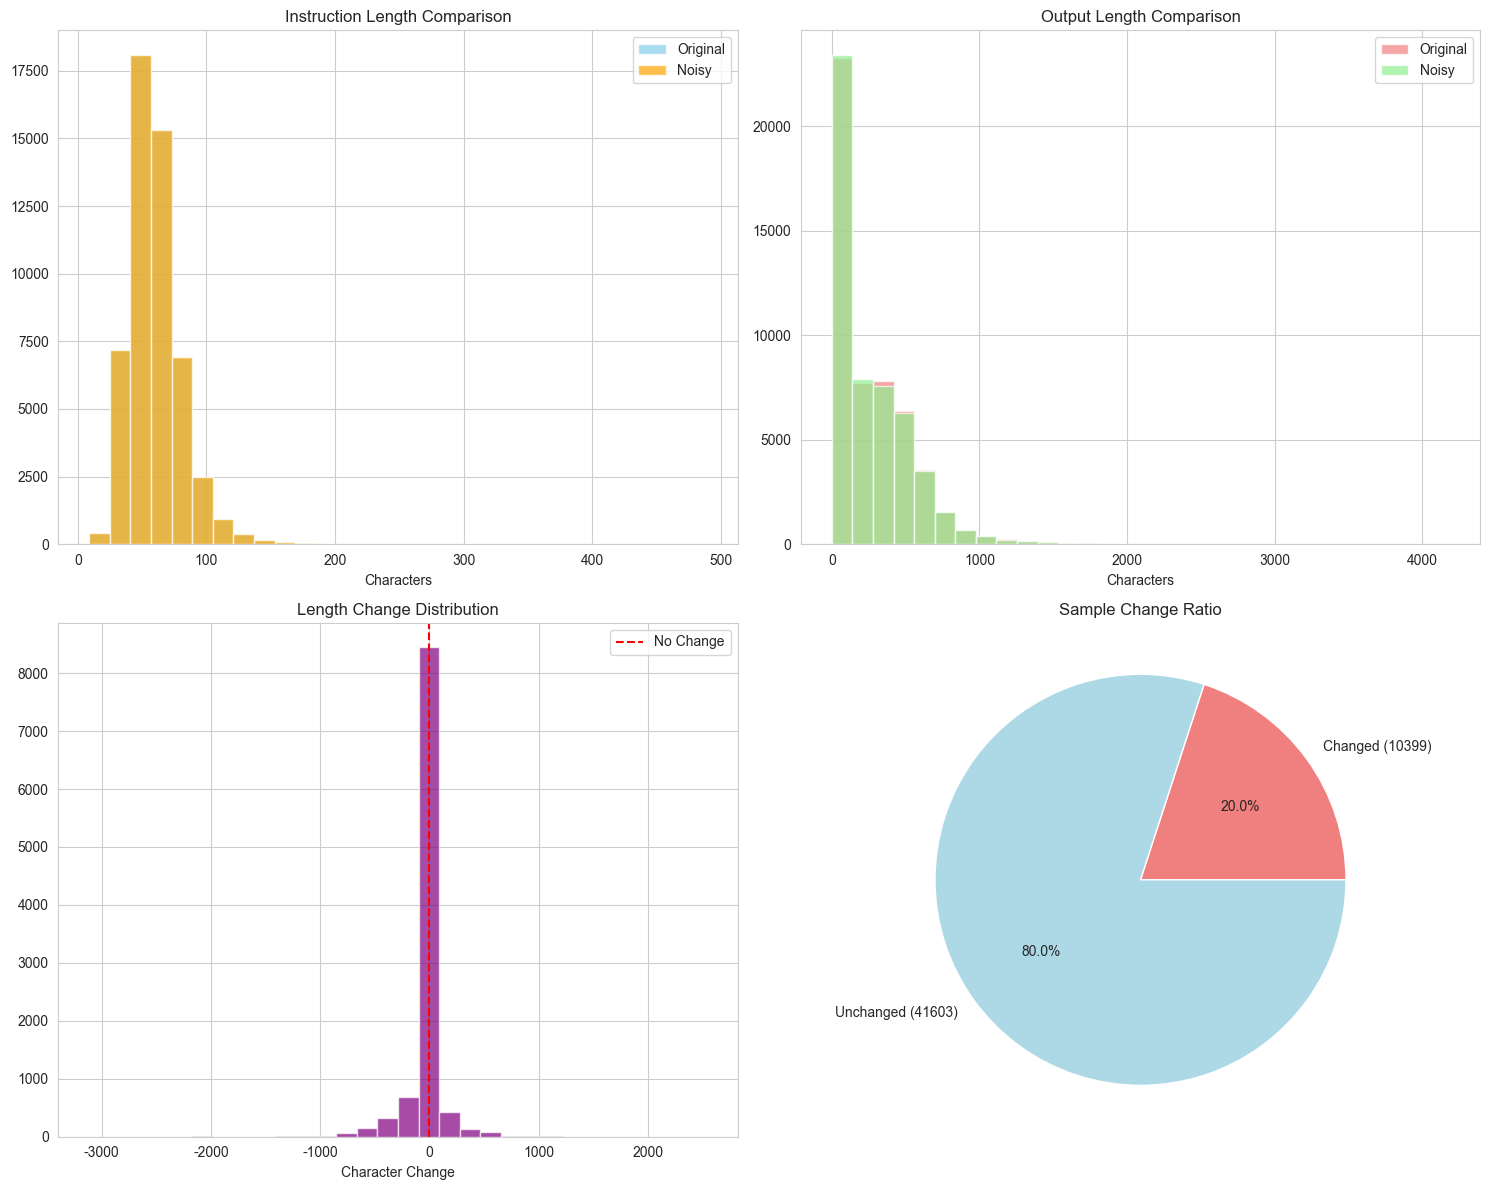

In [78]:
if noisy_files and df_original is not None and df_noisy is not None:
    # 길이 분포 비교 시각화
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Instruction 길이 비교
    axes[0, 0].hist(df_original['instruction_length'], bins=30, alpha=0.7, label='Original', color='skyblue')
    axes[0, 0].hist(df_noisy['instruction_length'], bins=30, alpha=0.7, label='Noisy', color='orange')
    axes[0, 0].set_title('Instruction Length Comparison')
    axes[0, 0].set_xlabel('Characters')
    axes[0, 0].legend()
    
    # Output 길이 비교
    axes[0, 1].hist(df_original['output_length'], bins=30, alpha=0.7, label='Original', color='lightcoral')
    axes[0, 1].hist(df_noisy['output_length'], bins=30, alpha=0.7, label='Noisy', color='lightgreen')
    axes[0, 1].set_title('Output Length Comparison')
    axes[0, 1].set_xlabel('Characters')
    axes[0, 1].legend()
    
    # 길이 변화 히스토그램
    if changed_indices:
        axes[1, 0].hist(length_changes, bins=30, alpha=0.7, color='purple')
        axes[1, 0].set_title('Length Change Distribution')
        axes[1, 0].set_xlabel('Character Change')
        axes[1, 0].axvline(x=0, color='red', linestyle='--', label='No Change')
        axes[1, 0].legend()
    
    # 변경 비율 파이차트
    changed_count = len(changed_indices)
    unchanged_count = len(df_original) - changed_count
    axes[1, 1].pie([changed_count, unchanged_count], 
                   labels=[f'Changed ({changed_count})', f'Unchanged ({unchanged_count})'],
                   autopct='%1.1f%%', colors=['lightcoral', 'lightblue'])
    axes[1, 1].set_title('Sample Change Ratio')
    
    plt.tight_layout()
    plt.show()

## 7. 샘플 비교 예시

In [80]:
if noisy_files and df_original is not None and df_noisy is not None and changed_indices:
    # 변경된 샘플 중 몇 개 예시 보기
    print("=== 노이즈 주입 전후 비교 예시 ===")
    
    sample_indices = np.random.choice(changed_indices, min(3, len(changed_indices)), replace=False)
    
    for i, idx in enumerate(sample_indices):
        print(f"\n[예시 {i+1}] 인덱스: {idx}")
        print("=" * 60)
        
        print("[원본]")
        print(f"Instruction: {df_original.iloc[idx]['instruction']}")
        print(f"Output: {df_original.iloc[idx]['output'][:200]}{'...' if len(df_original.iloc[idx]['output']) > 200 else ''}")
        
        print("\n[노이즈 주입 후]")
        print(f"Instruction: {df_noisy.iloc[idx]['instruction']}")
        print(f"Output: {df_noisy.iloc[idx]['output'][:200]}{'...' if len(df_noisy.iloc[idx]['output']) > 200 else ''}")
        
        # 변경사항 하이라이트
        inst_changed = df_original.iloc[idx]['instruction'] != df_noisy.iloc[idx]['instruction']
        out_changed = df_original.iloc[idx]['output'] != df_noisy.iloc[idx]['output']
        print(f"\n변경 필드: {'Instruction' if inst_changed else ''} {'Output' if out_changed else ''}")
        
        if out_changed:
            orig_len = len(df_original.iloc[idx]['output'])
            noisy_len = len(df_noisy.iloc[idx]['output'])
            print(f"길이 변화: {orig_len} -> {noisy_len} ({noisy_len - orig_len:+d})")

=== 노이즈 주입 전후 비교 예시 ===

[예시 1] 인덱스: 49298
[원본]
Instruction: Compare the density of H2O and H2S.
Output: The density of H2O is 1.00 g/cm³ while the density of H2S is 1.19 g/cm³, making H2S to be denser than H2O.

[노이즈 주입 후]
Instruction: Compare the density of H2O and H2S.
Output: The density of H2O is 1.00 g/cm³ while the density of H2S is 1.19 g/cm³, making H2S to be denser than H2O.???

변경 필드:  Output
길이 변화: 106 -> 109 (+3)

[예시 2] 인덱스: 32001
[원본]
Instruction: Connect the two pieces of text with a logical transition.
Output: The choice was easy; he had been through too much and was never going back.

[노이즈 주입 후]
Instruction: Connect the two pieces of text with a logical transition.
Output: This recipe contains approximately 620 calories, 33g fat, 62g carbohydrates and 21g protein per serving.

변경 필드:  Output
길이 변화: 75 -> 104 (+29)

[예시 3] 인덱스: 49401
[원본]
Instruction: Explain how using transitional words help in writing
Output: Using transitional words and phrases helps to smoothly lin

## 8. 데이터 품질 메트릭

In [81]:
if df_original is not None:
    # 품질 메트릭 계산
    def calculate_quality_metrics(df, name):
        metrics = {
            'dataset': name,
            'total_samples': len(df),
            'avg_instruction_length': df['instruction'].str.len().mean(),
            'avg_output_length': df['output'].str.len().mean(),
            'avg_instruction_words': df['instruction'].str.split().str.len().mean(),
            'avg_output_words': df['output'].str.split().str.len().mean(),
            'empty_outputs': (df['output'].str.len() == 0).sum(),
            'very_short_outputs': (df['output'].str.len() < 10).sum(),
            'very_long_outputs': (df['output'].str.len() > 1000).sum(),
        }
        return metrics
    
    # 원본 데이터 메트릭
    original_metrics = calculate_quality_metrics(df_original, 'Original')
    
    quality_results = [original_metrics]
    
    # 노이즈 데이터 메트릭 (있다면)
    if 'df_noisy' in locals() and df_noisy is not None:
        noisy_metrics = calculate_quality_metrics(df_noisy, f'Noisy ({selected_noisy})')
        quality_results.append(noisy_metrics)
    
    # 결과 출력
    quality_df = pd.DataFrame(quality_results)
    print("=== 데이터 품질 메트릭 ===")
    display(quality_df.set_index('dataset'))

=== 데이터 품질 메트릭 ===


,total_samples,avg_instruction_length,avg_output_length,avg_instruction_words,avg_output_words,empty_outputs,very_short_outputs,very_long_outputs
dataset,,,,,,,,
Original,52002,59.778759,270.312334,10.063632,44.182858,28,2388,999
Noisy (alpaca_full_20percent_52002.json),52002,59.803873,267.914253,10.068613,43.862025,26,2640,977


In [82]:
print("=== EDA 요약 ===")
print(f"\n분석된 파일 수: {len(data_files)}")
if df_original is not None:
    print(f"원본 데이터 샘플 수: {len(df_original)}")
    print(f"평균 Instruction 길이: {df_original['instruction_length'].mean():.1f} 문자")
    print(f"평균 Output 길이: {df_original['output_length'].mean():.1f} 문자")
    print(f"Instruction-Output 길이 상관계수: {df_original['instruction_length'].corr(df_original['output_length']):.3f}")

if noisy_files:
    print(f"\n노이즈 파일 수: {len(noisy_files)}")
    if changed_indices:
        print(f"실제 변경된 샘플 비율: {len(changed_indices)/len(df_original)*100:.1f}%")
        print(f"평균 길이 변화: {np.mean(length_changes):.1f} 문자")

print("\n=== DataInf 실험 준비 상태 ===")
has_original = any('original' in f for f in data_files)
has_noisy = len(noisy_files) > 0
has_variety = len(set(parse_filename_info(f)['noise_percent'] for f in data_files)) > 2

print(f"원본 데이터: {'✓' if has_original else '✗'}")
print(f"노이즈 데이터: {'✓' if has_noisy else '✗'}")
print(f"다양한 설정: {'✓' if has_variety else '✗'}")

readiness = sum([has_original, has_noisy, has_variety])
if readiness == 3:
    print("\n🎯 DataInf 실험 준비 완료!")
else:
    print(f"\n⚠️  추가 데이터 생성 권장 (준비도: {readiness}/3)")

=== EDA 요약 ===

분석된 파일 수: 3
원본 데이터 샘플 수: 52002
평균 Instruction 길이: 59.8 문자
평균 Output 길이: 270.3 문자
Instruction-Output 길이 상관계수: 0.016

노이즈 파일 수: 2
실제 변경된 샘플 비율: 20.0%
평균 길이 변화: -12.0 문자

=== DataInf 실험 준비 상태 ===
원본 데이터: ✓
노이즈 데이터: ✓
다양한 설정: ✗

⚠️  추가 데이터 생성 권장 (준비도: 2/3)


## 10. 추가 분석 (선택사항)

필요에 따라 아래 셀들을 사용하여 추가 분석을 수행할 수 있습니다.

In [83]:
# 여러 노이즈 파일 동시 비교 (있는 경우)
if len(noisy_files) > 1 and df_original is not None:
    print("=== 모든 노이즈 파일 비교 ===")
    
    comparison_data = []
    
    for noisy_file in noisy_files[:5]:  # 최대 5개까지만
        # 직접 경로로 데이터 로딩
        full_path = os.path.join("../data", noisy_file)
        try:
            df_temp = pd.read_json(full_path)
            if df_temp is not None:
                file_info = parse_filename_info(noisy_file)
                
                # 변경된 샘플 수 계산
                changes = 0
                for i in range(min(len(df_original), len(df_temp))):
                    if (df_original.iloc[i]['instruction'] != df_temp.iloc[i]['instruction'] or 
                        df_original.iloc[i]['output'] != df_temp.iloc[i]['output']):
                        changes += 1
                
                comparison_data.append({
                    'filename': noisy_file[:30] + '...' if len(noisy_file) > 30 else noisy_file,
                    'noise_percent': file_info['noise_percent'],
                    'strategy': file_info['strategy'],
                    'samples': len(df_temp),
                    'changed_samples': changes,
                    'change_ratio': f"{changes/len(df_temp)*100:.1f}%",
                    'avg_output_length': df_temp['output'].str.len().mean()
                })
        except Exception as e:
            print(f"파일 로딩 실패: {noisy_file} - {e}")
    
    if comparison_data:
        comparison_df = pd.DataFrame(comparison_data)
        display(comparison_df)

=== 모든 노이즈 파일 비교 ===


,filename,noise_percent,strategy,samples,changed_samples,change_ratio,avg_output_length
0,alpaca_full_20percent_52002.js...,20%,N/A,52002,10399,20.0%,267.914253
1,alpaca_full_dataset.json,N/A,N/A,52002,0,0.0%,270.312334
